In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib
import pandas
import numpy
print (matplotlib.__version__)
print (pandas.__version__)
print (numpy.__version__)

1.5.3
0.18.1
1.11.1


In [3]:
#Reading ratings file:
df = pd.read_csv('/home/serge/Desktop/Kanye/Hubert/Memoir/data/data/data.csv')

In [4]:
n_users = df.UserId.unique().shape[0]
n_jobs = df.JobId.unique().shape[0]
print (' Total Number of users = ' + str(n_users) + ' | Total Number of jobs = ' + str(n_jobs) )
n_users

 Total Number of users = 2500 | Total Number of jobs = 150


2500

In [5]:
#from sklearn import cross_validation as cv
from sklearn.cross_validation import train_test_split

train_data, test_data = train_test_split(df,test_size=0.25, random_state=0)
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# Create training and test matrix
R = np.zeros((n_users, n_jobs))
for line in train_data.itertuples():
    R[line[1]-1, line[2]-1] = line[3]  

T = np.zeros((n_users, n_jobs))
for line in test_data.itertuples():
    T[line[1]-1, line[2]-1] = line[3]

In [6]:
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

In [7]:

# Calculate the RMSE
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - np.dot(P.T,Q)))**2)/len(R[R > 0]))

In [8]:
lmbda = 0.2 # Regularisation weight
k = 20 # Dimensionality of latent feature space
m, n = R.shape # Number of users and items
n_epochs = 100 # Number of epochs

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
Q[0,:] = R[R != 0].mean(axis=0) # Avg. rating for each movie
E = np.eye(k) # (k x k)-dimensional idendity matrix

In [9]:
train_errors = []
test_errors = []

# Repeat until convergence
for epoch in range(n_epochs):
    # Fix Q and estimate P
    for i, Ii in enumerate(I):
        nui = np.count_nonzero(Ii) # Number of items user i has rated
        if (nui == 0): nui = 1 # Be aware of zero counts!
    
        # Least squares solution
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        Vi = np.dot(Q, np.dot(np.diag(Ii), R[i].T))
        P[:,i] = np.linalg.solve(Ai,Vi)
        
    # Fix P and estimate Q
    for j, Ij in enumerate(I.T):
        nmj = np.count_nonzero(Ij) # Number of users that rated item j
        if (nmj == 0): nmj = 1 # Be aware of zero counts!
        
        # Least squares solution
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), R[:,j]))
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    train_rmse = rmse(I,R,Q,P)
    test_rmse = rmse(I2,T,Q,P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
    print "[Epoch %d/%d] train error: %f, test error: %f" \
    %(epoch+1, n_epochs, train_rmse, test_rmse)
    
print "Algorithm converged"

[Epoch 1/100] train error: 1.849940, test error: 1.904858
[Epoch 2/100] train error: 1.365548, test error: 1.416960
[Epoch 3/100] train error: 1.296856, test error: 1.343428
[Epoch 4/100] train error: 1.269707, test error: 1.314048
[Epoch 5/100] train error: 1.255940, test error: 1.299298
[Epoch 6/100] train error: 1.247842, test error: 1.290882
[Epoch 7/100] train error: 1.242566, test error: 1.285669
[Epoch 8/100] train error: 1.238858, test error: 1.282256
[Epoch 9/100] train error: 1.236102, test error: 1.279930
[Epoch 10/100] train error: 1.233963, test error: 1.278300
[Epoch 11/100] train error: 1.232254, test error: 1.277133
[Epoch 12/100] train error: 1.230857, test error: 1.276284
[Epoch 13/100] train error: 1.229699, test error: 1.275660
[Epoch 14/100] train error: 1.228730, test error: 1.275196
[Epoch 15/100] train error: 1.227915, test error: 1.274849
[Epoch 16/100] train error: 1.227225, test error: 1.274589
[Epoch 17/100] train error: 1.226641, test error: 1.274392
[Epoch

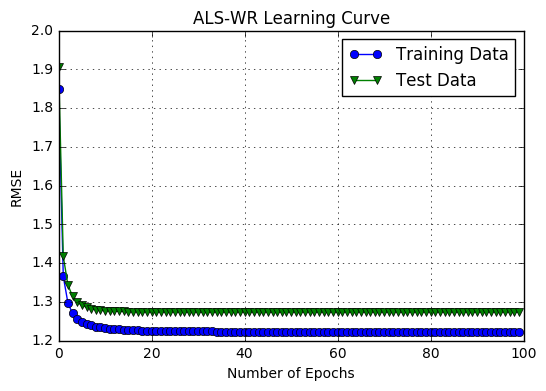

In [10]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [11]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R_hat = pd.DataFrame(np.dot(P.T,Q))
R = pd.DataFrame(R)

In [12]:
# Compare true ratings of user 17 with predictions
ratings = pd.DataFrame(data=R.loc[26,R.loc[26,:] > 0]).head(n=150)
ratings['Prediction'] = R_hat.loc[26,R.loc[26,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']

ratings

,Actual Rating,Predicted Rating
1,3.0,3.199917
10,4.0,3.239949
13,3.0,3.165206
15,5.0,3.274508
17,3.0,3.269554
18,3.0,3.193657
24,4.0,3.273677
25,1.0,3.214678
30,5.0,3.276366
31,2.0,3.171859


In [13]:
# Note that the firtst colomn stands for the job id the user  27 has rated

In [14]:
predictions = R_hat.loc[26,R.loc[26,:] == 0] # Predictions for jobs that the user 27 hasn't rated yet
top150 = predictions.sort_values(ascending=False).head(n=150)
recommendations = pd.DataFrame(data=top150)
recommendations.columns = ['Predicted Rating']

recommendations

,Predicted Rating
4,3.479793
58,3.403666
3,3.397855
113,3.392960
120,3.372727
23,3.348955
96,3.347257
37,3.345284
78,3.344394
38,3.342655


In [15]:
_14.to_csv('CF-ALS.csv')

In [16]:
train_data

,UserId,JobId,Rating
144305,325,88,4
6073,1741,45,5
8162,54,71,3
93080,765,54,4
154012,819,4,3
163353,435,53,4
144769,1731,66,5
115945,2101,95,4
3089,1738,131,4
37353,1478,148,4
